In [284]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
cm = sns.light_palette("green", as_cmap=True)

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [6]:
exchange = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
buyer = pd.read_csv('~/Documents/appreciate/buyer.csv')
imp_type

impression type  imp_type_id
0           banner            1
1            video            2
2           native            4
3     native video            8
4   rewarded video           16
5              IBV           32
6  rewarded banner           64

In [579]:
start_dt = '2021-04-01'
end_dt = '2021-04-28'
change_start_dt = '2021-04-08'
change_end_dt = '2021-04-08'

Extension of initial analysis done by Appreciate: 

(1) Overall CTR + IPM Improvement; broken down by ad format 

(2) Did we get new inventory because of this change?

(3) Or is existing inventory converting at high CTR/IPM Levels? 

(4) Monitor Rollout; If Auto-Pilot + ML Models are now bidding higher CPMs for MoPub Inventory (where we now have higher CTR/IPM)


## 1. Overall CTR + IPM Improvement; broken down by ad format

In [580]:
by_size_type = bigquery_client.query(f"""
select
    case when attr.ssb_buyer_id = 3549 then 'DT' else 'RON' end as buyer
    , attr.date
    , case 
        when attr.date <= '{change_start_dt}' then 0 
        when attr.date >= '{change_end_dt}' then 1
    else NULL end as with_change
    , attr.ad_size
    , attr.imp_type
    , count(case when cleared > 0 then 1 else NULL end)*16 as impressions
    , count(case when clicked > 0 then 1 else NULL end)*16 as clicks
    , count(case when installed > 0 then 1 else NULL end)*16 as installs
    , sum(revenue)*16 as spend
from stats.attributes attr 
join stats.events ev
    on attr.id = ev.id
where 
    attr.date >= '{start_dt}'
    and attr.date <= '{end_dt}'
    and left(attr.id,1) = '0'
    and attr.exchange_id = 3
group by 1,2,3,4,5
""").to_dataframe()
by_size_type = pd.merge(by_size_type, imp_type, left_on = 'imp_type', right_on = 'imp_type_id')
by_size_type['date'] = by_size_type['date'].astype('datetime64')
by_size_type

buyer       date  with_change   ad_size  imp_type  impressions  clicks  \
0     RON 2021-04-06            0  1024x768        16        10896    1024   
1      DT 2021-04-09            1  768x1024        16        13136     752   
2      DT 2021-04-19            1  768x1024        16        16240    1056   
3     RON 2021-04-27            1  768x1024        16        17312     944   
4     RON 2021-04-03            0  768x1024        16         9200     688   
..    ...        ...          ...       ...       ...          ...     ...   
777    DT 2021-04-09            1       0x0         4      1420752   14400   
778   RON 2021-04-16            1       0x0         4      2275680   10544   
779    DT 2021-04-21            1       0x0         4      1138048    6448   
780   RON 2021-04-02            0       0x0         4      2641776   14768   
781   RON 2021-04-14            1       0x0         4      2241888   10672   

     installs    spend impression type  imp_type_id  
0          16     2.88  rewarded video           16  
1          16     8.00  rewarded video           16  
2          16    36.00  rewarded video           16  
3          48    18.56  rewarded video           16  
4           0     0.00  rewarded video           16  
..        ...      ...             ...          ...  
777       672  1340.00          native            4  
778        16     8.00          native            4  
779       528  1056.00          native            4  
780       848   862.88          native            4  
781         0      NaN          native            4  

[782 rows x 11 columns]

In [581]:
by_size_type_dt = by_size_type[by_size_type.buyer == 'DT']

In [582]:
def calc_metrics(x):
    x.at[:,'ctr'] = x.loc[:,'clicks']/x.loc[:,'impressions']
    x.at[:,'ir'] = x.loc[:,'installs']/x.loc[:,'clicks']
    x.at[:,'ipm'] = 1000*x.loc[:,'installs']/x.loc[:,'impressions']
    x.at[:,'cpi'] = x.loc[:,'spend']/x.loc[:,'installs']

def format_display(df):
    format_mapping = {'impressions':'{:,.0f}'
                     ,'clicks':'{:,.0f}'
                     ,'installs':'{:,.0f}'
                     ,'spend':'${:,.0f}'
                     ,'cpi':'${:,.2f}'
                     ,'ctr':'{:.1f}%'
                     ,'ir':'{:.1f}%'
                     ,'ipm':'{:.2f}'
                     }
    df = df[['impressions','clicks','ctr','installs','ir','ipm','cpi','spend']]
    df[['ctr','ir']] = df[['ctr','ir']]*100
    df['cpi'] = df['cpi'].fillna(0)
    return df.style.format(format_mapping)

In [583]:
change_total = by_size_type_dt.groupby('with_change')['impressions','clicks','installs','spend'].sum()
calc_metrics(change_total)
format_display(change_total)

<ipython-input-583-8ecb4d10f329>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  change_total = by_size_type_dt.groupby('with_change')['impressions','clicks','installs','spend'].sum()


In [584]:
by_day_total = by_size_type_dt.groupby('date')['impressions','clicks','installs','spend'].sum()
calc_metrics(by_day_total)
format_display(by_day_total)

<ipython-input-584-eba4fdd0bc9b>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_day_total = by_size_type_dt.groupby('date')['impressions','clicks','installs','spend'].sum()


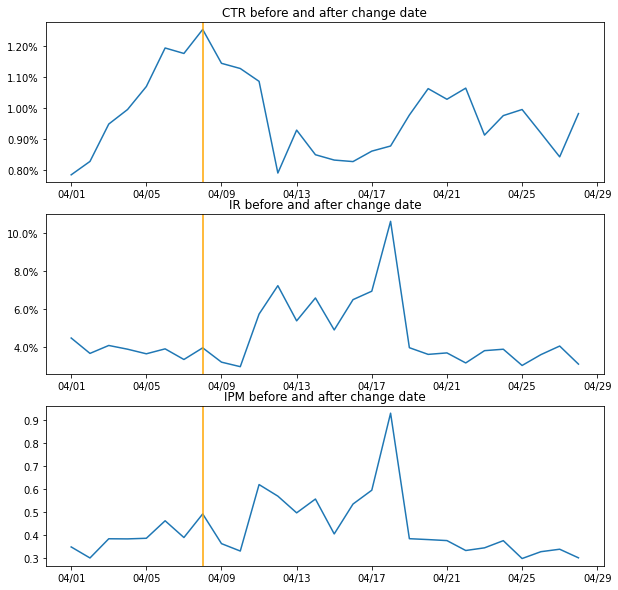

In [585]:
fig, ax = plt.subplots(3,1, figsize = (10,10))
ax[0].plot(by_day_total[['ctr']]*100)
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[0].set_title('CTR before and after change date')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax[1].plot(by_day_total[['ir']]*100)
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[1].set_title('IR before and after change date')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax[2].plot(by_day_total[['ipm']])
ax[2].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[2].set_title('IPM before and after change date')
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

In [586]:
change_type = by_size_type_dt.groupby(['impression type','with_change'])['impressions','clicks','installs','spend'].sum()
calc_metrics(change_type)
format_display(change_type)

<ipython-input-586-6b03aa574766>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  change_type = by_size_type_dt.groupby(['impression type','with_change'])['impressions','clicks','installs','spend'].sum()


In [587]:
by_day_type = by_size_type_dt.groupby(['impression type','date'])['impressions','clicks','installs','spend'].sum()
by_day_type.reset_index(inplace = True)
by_day_type['group_sum'] = by_day_type.groupby('impression type')['spend'].transform(sum)
by_day_type.sort_values(['group_sum','date'], ascending = [False, True], inplace = True)
by_day_type.set_index(['impression type','date'], inplace = True)
calc_metrics(by_day_type)
format_display(by_day_type)

<ipython-input-587-735db360b180>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_day_type = by_size_type_dt.groupby(['impression type','date'])['impressions','clicks','installs','spend'].sum()
/Users/daniel.ryu/Library/Python/3.8/lib/python/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-582-c126b29e200c>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

impression type
banner            122762.88
native             46987.20
video               5833.28
rewarded video      2660.00
Name: spend, dtype: float64


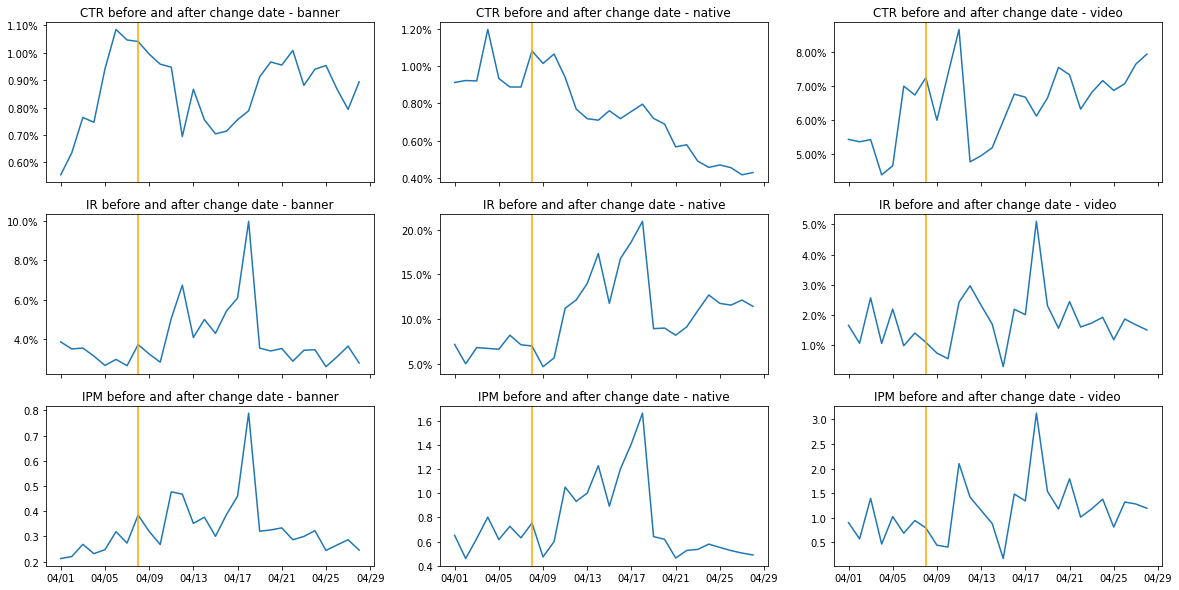

In [722]:
print(by_size_type_dt.groupby('impression type')['spend'].sum().sort_values(ascending = False))

fig, ax = plt.subplots(3,3, figsize = (20,10),sharex = True)

for n in range(3):
    type_filter = by_day_type.index.get_level_values(0).unique()[n]
    filtered_by_type = by_day_type.loc[type_filter]
    ax[0,n].plot(pd.DataFrame(filtered_by_type['ctr']*100))
    ax[0,n].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[0,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[0,n].set_title(f'CTR before and after change date - {type_filter}')
    ax[0,n].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax[1,n].plot(pd.DataFrame(filtered_by_type['ir']*100))
    ax[1,n].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[1,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[1,n].set_title(f'IR before and after change date - {type_filter}')
    ax[1,n].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax[2,n].plot(pd.DataFrame(filtered_by_type['ipm']))
    ax[2,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[2,n].set_title(f'IPM before and after change date - {type_filter}')
    ax[2,n].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

In [715]:
by_day_size_banners_dt = by_size_type_dt[by_size_type_dt['impression type'] == 'banner'].groupby(['ad_size','date'])['impressions','clicks','installs','spend'].sum()
by_day_size_banners_dt.reset_index(inplace = True)
by_day_size_banners_dt['group_sum'] = by_day_size_banners_dt.groupby('ad_size')['spend'].transform(sum)
by_day_size_banners_dt.sort_values(['group_sum','date'], ascending = [False, True], inplace = True)
by_day_size_banners_dt.set_index(['ad_size','date'], inplace = True)
calc_metrics(by_day_size_banners_dt)
format_display(by_day_size_banners_dt)

<ipython-input-715-c2615a97b643>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_day_size_banners_dt = by_size_type_dt[by_size_type_dt['impression type'] == 'banner'].groupby(['ad_size','date'])['impressions','clicks','installs','spend'].sum()
<ipython-input-582-c126b29e200c>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cpi'] = df['cpi'].fillna(0)


<ipython-input-725-6317c693d1b5>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(by_size_type_dt[by_size_type['impression type'] == 'banner'].groupby('ad_size')['spend'].sum().sort_values(ascending = False))


ad_size
320x50      78161.60
320x480     24193.28
300x250     18536.80
480x320      1807.20
300x50         32.00
728x90         32.00
1024x768        0.00
768x1024        0.00
Name: spend, dtype: float64


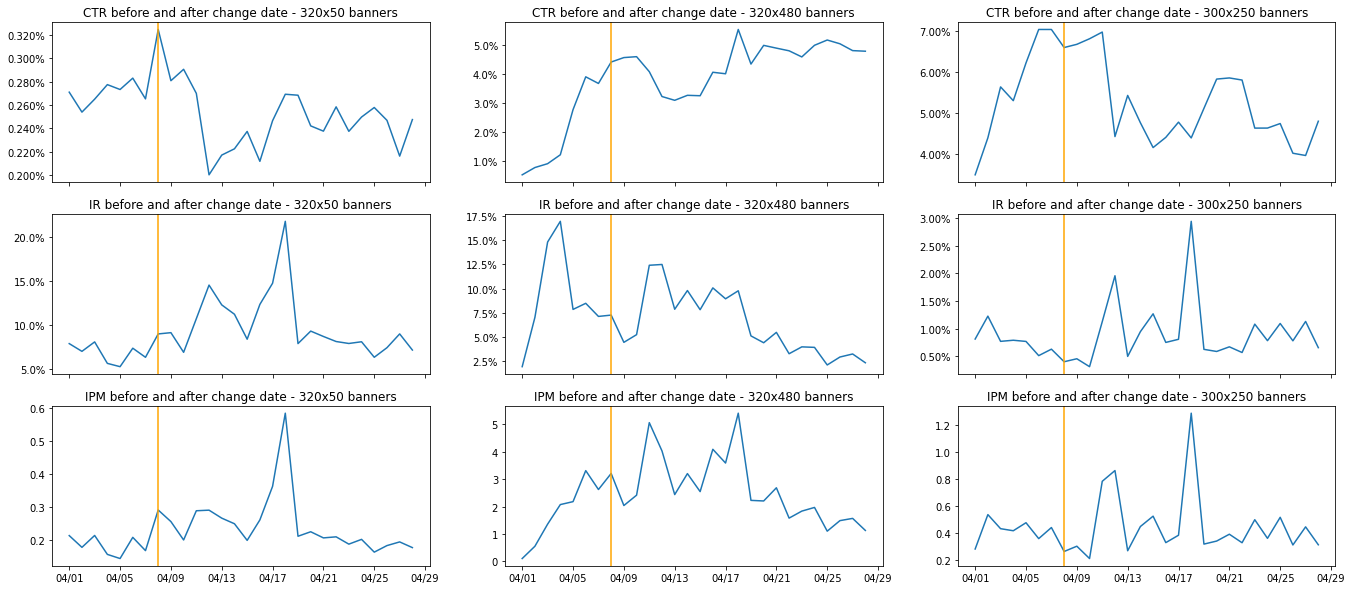

In [725]:
print(by_size_type_dt[by_size_type['impression type'] == 'banner'].groupby('ad_size')['spend'].sum().sort_values(ascending = False))

fig, ax = plt.subplots(3,3, figsize = (23,10), sharex = True)
for n in range(3):
    size_filter = by_day_size_banners_dt.index.get_level_values(0).unique()[n]
    filtered_by_size = by_day_size_banners_dt.loc[size_filter]
    ax[0,n].plot(pd.DataFrame(filtered_by_size['ctr']*100))
    ax[0,n].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[0,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[0,n].set_title(f'CTR before and after change date - {size_filter} banners')
    ax[1,n].plot(pd.DataFrame(filtered_by_size['ir']*100))
    ax[1,n].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[1,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[1,n].set_title(f'IR before and after change date - {size_filter} banners')
    ax[2,n].plot(pd.DataFrame(filtered_by_size['ipm']))
    ax[2,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[2,n].set_title(f'IPM before and after change date - {size_filter} banners')
    ax[2,n].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

<ipython-input-595-19bf58fbac26>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(by_size_type_dt[by_size_type['impression type'] == 'banner'].groupby('ad_size')['spend'].sum().sort_values(ascending = False))


ad_size
320x50      78161.60
320x480     24193.28
300x250     18536.80
480x320      1807.20
300x50         32.00
728x90         32.00
1024x768        0.00
768x1024        0.00
Name: spend, dtype: float64


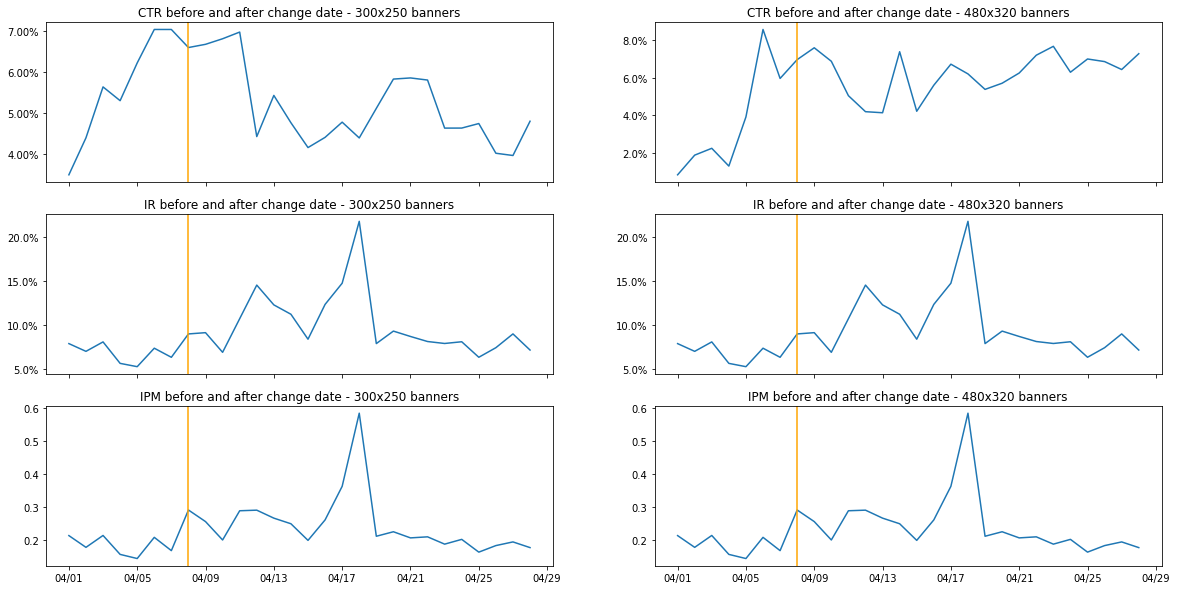

In [595]:
print(by_size_type_dt[by_size_type['impression type'] == 'banner'].groupby('ad_size')['spend'].sum().sort_values(ascending = False))

fig, ax = plt.subplots(3,2, figsize = (20,10), sharex = True)
size_filter = by_day_size_banners_dt.index.get_level_values(0).unique()[2]
filtered_by_size = by_day_size_banners_dt.loc[size_filter]
ax[0,0].plot(pd.DataFrame(filtered_by_size['ctr']*100))
ax[0,0].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[0,0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[0,0].set_title(f'CTR before and after change date - {size_filter} banners')
ax[1,0].plot(by_day_size_banners_dt.loc[by_day_size_banners_dt.index.get_level_values(0).unique()[0], 'ir']*100)
ax[1,0].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1,0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[1,0].set_title(f'IR before and after change date - {size_filter} banners')
ax[2,0].plot(by_day_size_banners_dt.loc[by_day_size_banners_dt.index.get_level_values(0).unique()[0], 'ipm'])
ax[2,0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[2,0].set_title(f'IPM before and after change date - {size_filter} banners')
ax[2,0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

size_filter = by_day_size_banners_dt.index.get_level_values(0).unique()[3]
filtered_by_size = by_day_size_banners_dt.loc[size_filter]
ax[0,1].plot(pd.DataFrame(filtered_by_size['ctr']*100))
ax[0,1].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[0,1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[0,1].set_title(f'CTR before and after change date - {size_filter} banners')
ax[1,1].plot(by_day_size_banners_dt.loc[by_day_size_banners_dt.index.get_level_values(0).unique()[0], 'ir']*100)
ax[1,1].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1,1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[1,1].set_title(f'IR before and after change date - {size_filter} banners')
ax[2,1].plot(by_day_size_banners_dt.loc[by_day_size_banners_dt.index.get_level_values(0).unique()[0], 'ipm'])
ax[2,1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[2,1].set_title(f'IPM before and after change date - {size_filter} banners')
ax[2,1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

## 2. Did we get new inventory because of this change?

In [596]:
by_app_type = bigquery_client.query(f"""
select
    case when attr.ssb_buyer_id = 3549 then 'DT' else 'RON' end as buyer
    , attr.date
    , case 
        when attr.date <= '{change_start_dt}' then 0 
        when attr.date >= '{change_end_dt}' then 1
    else NULL end as with_change
    , attr.ad_size
    , attr.imp_type
    , attr.hosting_app_id
    , count(case when cleared > 0 then 1 else NULL end)*16 as impressions
    , count(case when clicked > 0 then 1 else NULL end)*16 as clicks
    , count(case when installed > 0 then 1 else NULL end)*16 as installs
    , sum(revenue)*16 as spend
from stats.attributes attr 
join stats.events ev
    on attr.id = ev.id
where 
    attr.date >= '{start_dt}'
    and attr.date <= '{end_dt}'
    and left(attr.id,1) = '0'
    and attr.exchange_id = 3
group by 1,2,3,4,5,6
""").to_dataframe()
by_app_type = pd.merge(by_app_type, imp_type, left_on = 'imp_type', right_on = 'imp_type_id')
by_app_type['date'] = by_app_type['date'].astype('datetime64')
by_app_type

buyer       date  with_change  ad_size  imp_type  hosting_app_id  \
0         DT 2021-04-01            0  300x250         1      1458308488   
1        RON 2021-04-01            0  300x250         1          124381   
2         DT 2021-04-01            0   320x50         1         1196724   
3        RON 2021-04-01            0  320x480         1         1010157   
4        RON 2021-04-01            0   320x50         1          743286   
...      ...        ...          ...      ...       ...             ...   
227455   RON 2021-04-28            1  480x320        64          814324   
227456   RON 2021-04-28            1  480x320        64         1173861   
227457   RON 2021-04-28            1  320x480        64         1253127   
227458   RON 2021-04-28            1  320x480        64         1112087   
227459   RON 2021-04-28            1  320x480        64         1122768   

        impressions  clicks  installs  spend  impression type  imp_type_id  
0               128      96         0    0.0           banner            1  
1               224       0         0    0.0           banner            1  
2               208       0         0    0.0           banner            1  
3                80       0         0    0.0           banner            1  
4               640      64         0    0.0           banner            1  
...             ...     ...       ...    ...              ...          ...  
227455           48       0         0    NaN  rewarded banner           64  
227456           16       0         0    NaN  rewarded banner           64  
227457          256      16         0    NaN  rewarded banner           64  
227458           32       0         0    NaN  rewarded banner           64  
227459           16       0         0    NaN  rewarded banner           64  

[227460 rows x 12 columns]

In [597]:
by_app_type_dt = by_app_type[by_app_type.buyer == 'DT']

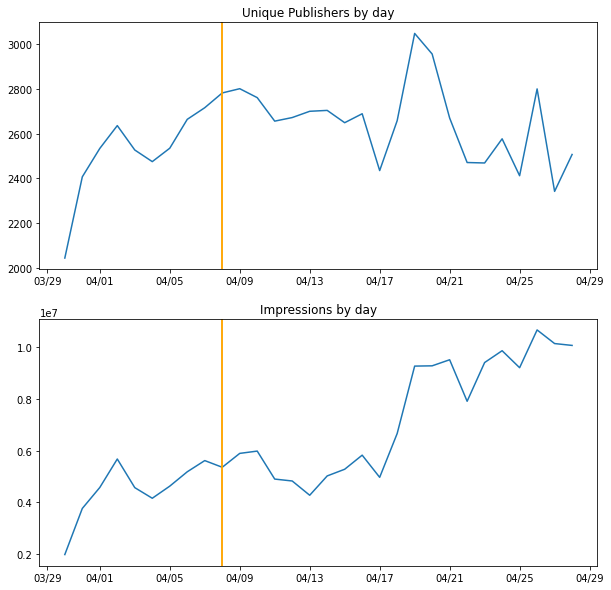

In [534]:
by_date = by_app_type_dt.pivot_table(values = ['hosting_app_id','impressions'], index = 'date', aggfunc = {'hosting_app_id':lambda x:len(x.unique()), 'impressions':sum})
fig, ax = plt.subplots(2,1,figsize = (10,10))
ax[0].plot(by_date['hosting_app_id'])
ax[0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[0].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[0].set_title('Unique Publishers by day')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax[1].plot(by_date['impressions'])
ax[1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[1].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[1].set_title('Impressions by day')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

                 hosting_app_id  impressions
impression type                             
banner                     5010    155465088
video                      1599      3485648
native                     1035     34456288
rewarded video              706       926928


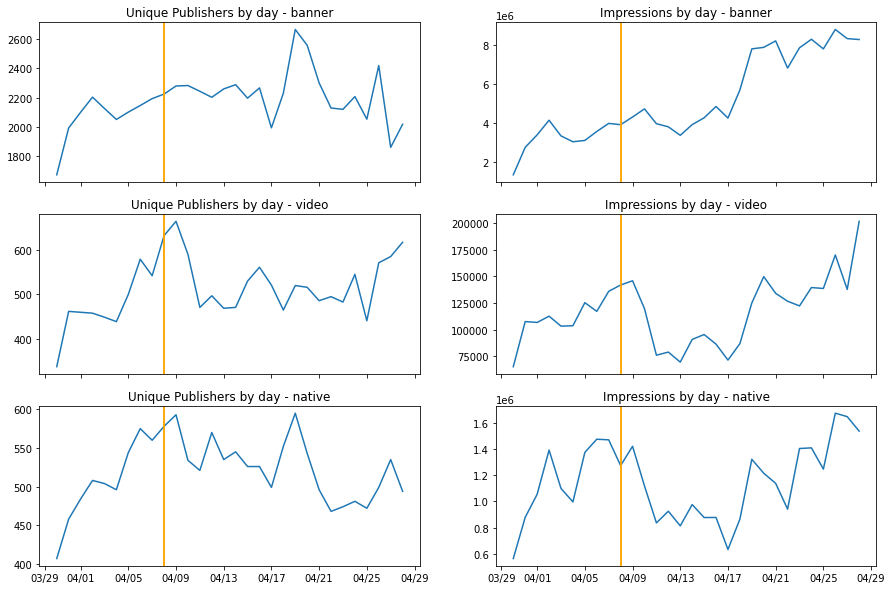

In [578]:
print(by_app_type_dt.pivot_table(values = ['hosting_app_id','impressions'], index = 'impression type', aggfunc = {'hosting_app_id':lambda x:len(x.unique()), 'impressions':sum}).sort_values('hosting_app_id', ascending = False))

by_date_type = by_app_type_dt.pivot_table(values = ['hosting_app_id','impressions'], index = 'date', columns = 'impression type', aggfunc = {'hosting_app_id':lambda x:len(x.unique()), 'impressions':sum})
fig, ax = plt.subplots(3,2,figsize = (15,10), sharex = True)

for n in range(3):
    type_filter = by_app_type_dt['impression type'].unique()[n]
    filtered_type = by_date_type.loc[:,by_date_type.columns.get_level_values(1) == type_filter]
    ax[n,0].plot(filtered_type['hosting_app_id'])
    ax[n,0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[n,0].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[n,0].set_title(f'Unique Publishers by day - {type_filter}')
    ax[n,1].plot(filtered_type['impressions'])
    ax[n,1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[n,1].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[n,1].set_title(f'Impressions by day - {type_filter}')
    ax[n,0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax[n,1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

In [536]:
prev_apps = bigquery_client.query(f"""
select
    case when attr.ssb_buyer_id = 3549 then 'DT' else 'RON' end as buyer
    , attr.hosting_app_id
    , count(*)*16 as prev_impressions
from stats.attributes attr 
where 
    attr.date >= '{start_dt}' - 60 
    and attr.date <= '{start_dt}' - 1
    and left(attr.id,1) = '0'
    and attr.exchange_id = 3
group by 1,2
""").to_dataframe()
prev_apps

buyer  hosting_app_id  prev_impressions
0      RON       625458492               352
1      RON      1474598066               464
2      RON         1142479                80
3      RON          105253              2656
4      RON         1221698              1632
...    ...             ...               ...
2006   RON          878136                16
2007   RON          407391                16
2008   RON         1275018                32
2009   RON         1199769                16
2010   RON          752352                16

[2011 rows x 3 columns]

In [537]:
prev_apps_dt = prev_apps[prev_apps.buyer == 'DT']
new_apps_dt = by_app_type_dt.set_index(['buyer','hosting_app_id']).join(prev_apps_dt.set_index(['buyer','hosting_app_id']), how = 'left').reset_index()
new_apps_dt = new_apps_dt[(new_apps_dt.prev_impressions == 0) | (new_apps_dt.prev_impressions.isna())]
new_apps_dt


hosting_app_id buyer       date  with_change ad_size  imp_type  \
210              43202    DT 2021-04-02            0  320x50         1   
211              43202    DT 2021-04-14            1  320x50         1   
212              43202    DT 2021-04-15            1  320x50         1   
213              43202    DT 2021-04-21            1  320x50         1   
273              49870    DT 2021-04-10            0  320x50         1   
...                ...   ...        ...          ...     ...       ...   
109534      1561184462    DT 2021-04-22            1  320x50         1   
109535      1561184462    DT 2021-04-23            1  320x50         1   
109536      1561184462    DT 2021-04-24            1  320x50         1   
109537      1561184462    DT 2021-04-25            1  320x50         1   
109538      1561184462    DT 2021-04-26            1  320x50         1   

        impressions  clicks  installs  spend impression type  imp_type_id  \
210              16       0         0    0.0          banner            1   
211              80       0         0    NaN          banner            1   
212              32       0         0    NaN          banner            1   
213              16       0         0    NaN          banner            1   
273              16       0         0    0.0          banner            1   
...             ...     ...       ...    ...             ...          ...   
109534           32       0         0    NaN          banner            1   
109535           32       0         0    NaN          banner            1   
109536           96       0         0    NaN          banner            1   
109537           32       0         0    NaN          banner            1   
109538          208       0         0    NaN          banner            1   

        prev_impressions  
210                  NaN  
211                  NaN  
212                  NaN  
213                  NaN  
273                  NaN  
...                  ...  
109534               NaN  
109535               NaN  
109536               NaN  
109537               NaN  
109538               NaN  

[12529 rows x 13 columns]

Text(0.5, 1.0, 'Impressions from New Publishers by day')

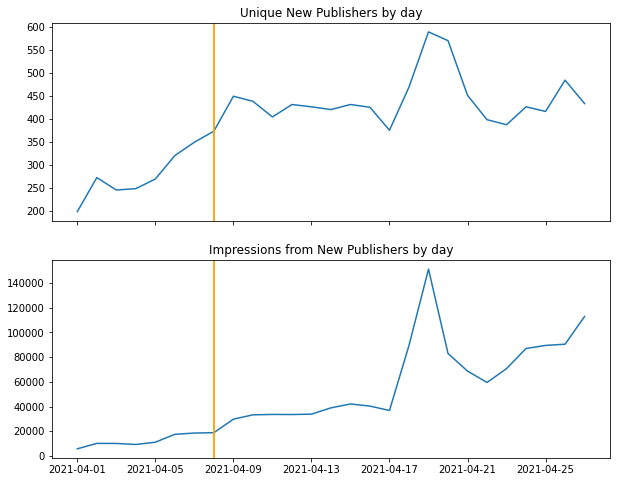

In [538]:
new_apps_byday = new_apps_dt.pivot_table(values = ['hosting_app_id','impressions'], index = 'date', aggfunc = {'hosting_app_id':lambda x:len(x.unique()), 'impressions':sum})
fig, ax = plt.subplots(2,1,figsize = (10,8), sharex = True)

ax[0].plot(new_apps_byday['hosting_app_id'])
ax[0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[0].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[0].set_title(f'Unique New Publishers by day')
ax[1].plot(new_apps_byday['impressions'])
ax[1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[1].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[1].set_title(f'Impressions from New Publishers by day')

impression type
banner            1102976
native             123936
video               58560
rewarded video      40400
Name: impressions, dtype: int64


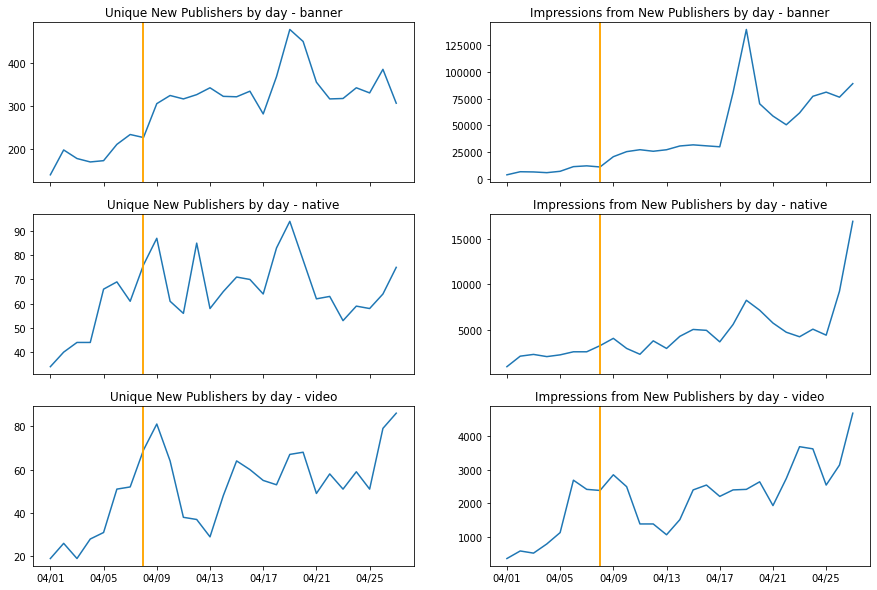

In [539]:
print(new_apps_dt.groupby('impression type')['impressions'].sum().sort_values(ascending = False))

new_apps_byday_bytype = new_apps_dt.pivot_table(values = ['hosting_app_id','impressions'], index = 'date', columns = 'impression type', aggfunc = {'hosting_app_id':lambda x:len(x.unique()), 'impressions':sum})
fig, ax = plt.subplots(3,2,figsize = (15,10), sharex = True)

for n in range(3):
    type_filter = new_apps_dt['impression type'].unique()[n]
    filtered_type = new_apps_byday_bytype.loc[:,new_apps_byday_bytype.columns.get_level_values(1) == type_filter]
    ax[n,0].plot(filtered_type['hosting_app_id'])
    ax[n,0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[n,0].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[n,0].set_title(f'Unique New Publishers by day - {type_filter}')
    ax[n,1].plot(filtered_type['impressions'])
    ax[n,1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[n,1].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[n,1].set_title(f'Impressions from New Publishers by day - {type_filter}')
    ax[n,0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax[n,1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

ad_size
320x50      908512
320x480     151168
480x320      22640
300x250      13552
300x50        6608
1024x768       256
768x1024       240
Name: impressions, dtype: int64


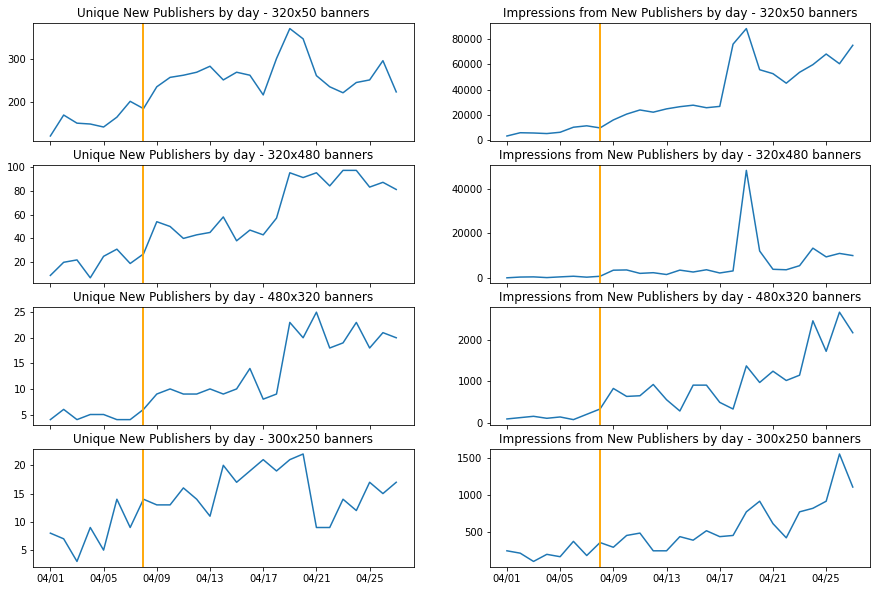

In [727]:
print(new_apps_dt[new_apps_dt['impression type'] == 'banner'].groupby('ad_size')['impressions'].sum().sort_values(ascending = False))
top_banner_sizes = new_apps_dt[new_apps_dt['impression type'] == 'banner'].groupby('ad_size')['impressions'].sum().sort_values(ascending = False).index.to_list()

new_apps_byday_bysize = new_apps_dt[new_apps_dt['impression type'] == 'banner'].pivot_table(values = ['hosting_app_id','impressions'], index = 'date', columns = 'ad_size', aggfunc = {'hosting_app_id':lambda x:len(x.unique()), 'impressions':sum})
fig, ax = plt.subplots(4,2,figsize = (15,10), sharex = True)

for n in range(4):
    size_filter = top_banner_sizes[n]
    filtered_size = new_apps_byday_bysize.loc[:,new_apps_byday_bysize.columns.get_level_values(1) == size_filter]
    ax[n,0].plot(filtered_size['hosting_app_id'])
    ax[n,0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[n,0].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[n,0].set_title(f'Unique New Publishers by day - {size_filter} banners')
    ax[n,1].plot(filtered_size['impressions'])
    ax[n,1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[n,1].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[n,1].set_title(f'Impressions from New Publishers by day - {size_filter} banners')
    ax[n,0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax[n,1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

## 3. Or is existing inventory converting at high CTR/IPM Levels?

In [615]:
existing_apps_dt = by_app_type_dt.set_index(['buyer','hosting_app_id']).join(prev_apps_dt.set_index(['buyer','hosting_app_id']), how = 'inner').reset_index()
top_banner_sizes = existing_apps_dt[existing_apps_dt['impression type'] == 'banner'].groupby('ad_size')['impressions'].sum().sort_values(ascending = False).index.to_list()

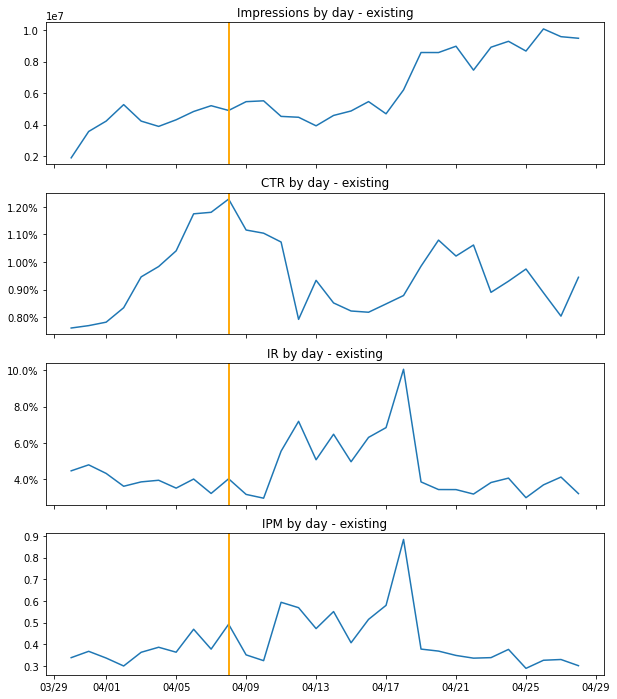

In [541]:
existing_apps_byday_dt = existing_apps_dt.pivot_table(values = ['impressions','clicks','installs','spend'], index = 'date', aggfunc = sum)

calc_metrics(existing_apps_byday_dt)
fig, ax = plt.subplots(4,1,figsize = (10,12), sharex = True)
ax[0].plot(existing_apps_byday_dt['impressions'])
ax[0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[0].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[0].set_title(f'Impressions by day - existing')
ax[1].plot(existing_apps_byday_dt['ctr']*100)
ax[1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[1].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[1].set_title(f'CTR by day - existing')
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[2].plot(existing_apps_byday_dt['ir']*100)
ax[2].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[2].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[2].set_title(f'IR by day - existing')
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[3].plot(existing_apps_byday_dt['ipm'])
ax[3].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[3].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[3].set_title(f'IPM by day - existing')
ax[3].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

<ipython-input-733-44a1127be957>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['ctr'] = sub_df['clicks']/sub_df['impressions']
<ipython-input-733-44a1127be957>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['ir'] = sub_df['installs']/sub_df['clicks']
<ipython-input-733-44a1127be957>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

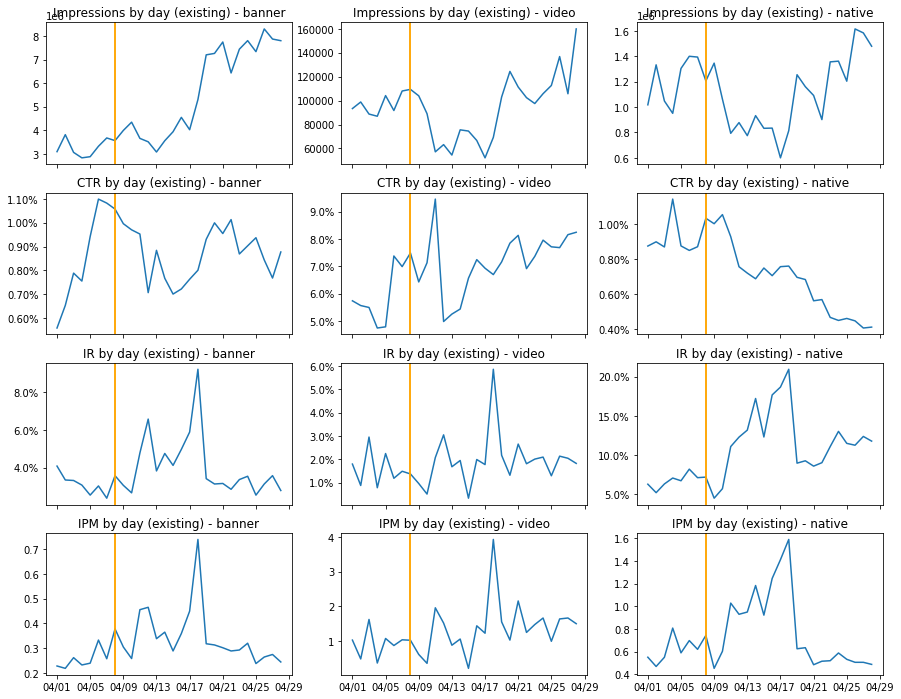

In [733]:
existing_apps_byday_bytype = existing_apps_dt.pivot_table(values = ['impressions','clicks','installs','spend'], index = 'date', columns = 'impression type', aggfunc = sum)
fig, ax = plt.subplots(4,3,figsize = (15,12), sharex = True)

for n in [1,0,2]:
    type_filter = existing_apps_dt['impression type'].unique()[n]
    sub_df = existing_apps_byday_bytype.loc[:,existing_apps_byday_bytype.columns.get_level_values(1) == type_filter]
    sub_df.columns = sub_df.columns.get_level_values(0)
    sub_df['ctr'] = sub_df['clicks']/sub_df['impressions']
    sub_df['ir'] = sub_df['installs']/sub_df['clicks']
    sub_df['ipm'] = 1000*sub_df['installs']/sub_df['impressions']
    ax[0,n].plot(sub_df['impressions'])
    ax[0,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[0,n].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[0,n].set_title(f'Impressions by day (existing) - {type_filter}')
    ax[1,n].plot(sub_df['ctr']*100)
    ax[1,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[1,n].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[1,n].set_title(f'CTR by day (existing) - {type_filter}')
    ax[1,n].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[2,n].plot(sub_df['ir']*100)
    ax[2,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[2,n].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[2,n].set_title(f'IR by day (existing) - {type_filter}')
    ax[2,n].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[3,n].plot(sub_df['ipm'])
    ax[3,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[3,n].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[3,n].set_title(f'IPM by day (existing) - {type_filter}')
    ax[3,n].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))


<ipython-input-616-bac95cd9a38e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['ctr'] = sub_df['clicks']/sub_df['impressions']
<ipython-input-616-bac95cd9a38e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['ir'] = sub_df['installs']/sub_df['clicks']
<ipython-input-616-bac95cd9a38e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

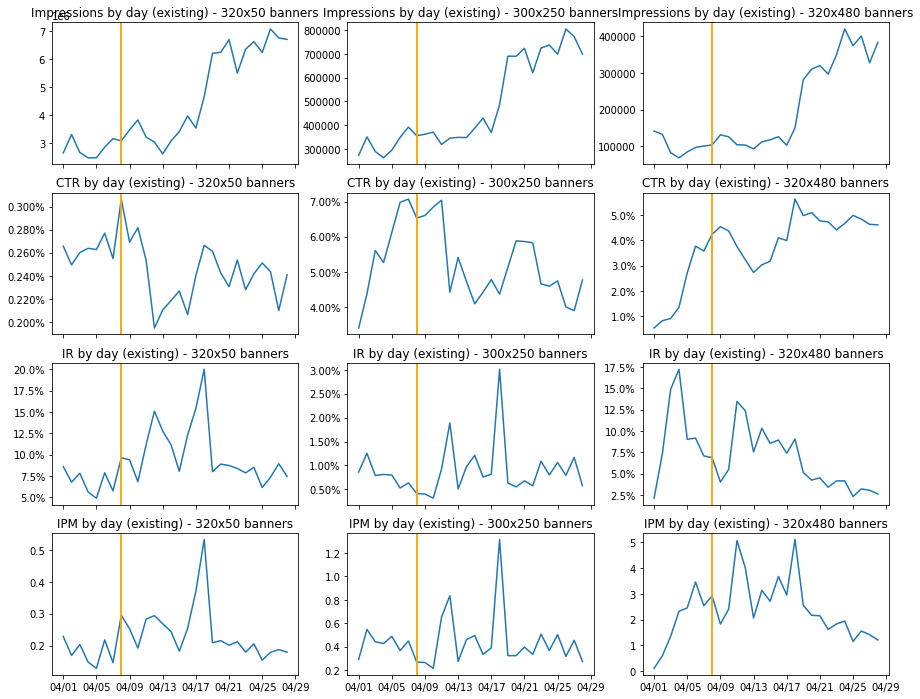

In [616]:
existing_apps_byday_bysize_banners_dt = existing_apps_dt[existing_apps_dt['impression type'] == 'banner'].pivot_table(values = ['impressions','clicks','installs','spend'], index = 'date', columns = 'ad_size', aggfunc = sum)
fig, ax = plt.subplots(4,3,figsize = (15,12), sharex = True)

for n in range(3):
    size_filter = top_banner_sizes[n]
    sub_df = existing_apps_byday_bysize_banners_dt.loc[:,existing_apps_byday_bysize_banners_dt.columns.get_level_values(1) == size_filter]
    sub_df.columns = sub_df.columns.get_level_values(0)
    sub_df['ctr'] = sub_df['clicks']/sub_df['impressions']
    sub_df['ir'] = sub_df['installs']/sub_df['clicks']
    sub_df['ipm'] = 1000*sub_df['installs']/sub_df['impressions']
    ax[0,n].plot(sub_df['impressions'])
    ax[0,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[0,n].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[0,n].set_title(f'Impressions by day (existing) - {size_filter} banners')
    ax[1,n].plot(sub_df['ctr']*100)
    ax[1,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[1,n].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[1,n].set_title(f'CTR by day (existing) - {size_filter} banners')
    ax[1,n].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[2,n].plot(sub_df['ir']*100)
    ax[2,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[2,n].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[2,n].set_title(f'IR by day (existing) - {size_filter} banners')
    ax[2,n].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[3,n].plot(sub_df['ipm'])
    ax[3,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[3,n].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[3,n].set_title(f'IPM by day (existing) - {size_filter} banners')
    ax[3,n].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))


## 4. Monitor Rollout; If Auto-Pilot + ML Models are now bidding higher CPMs for MoPub Inventory (where we now have higher CTR/IPM)

In [617]:
bidding_df = bigquery_client.query(f"""
select
    case when attr.ssb_buyer_id = 3549 then 'DT' else 'RON' end as buyer
    , attr.date
    , case 
        when attr.date <= '{change_start_dt}' then 0 
        when attr.date >= '{change_end_dt}' then 1
    else NULL end as with_change
    , case when cr_model = 'production' or ctr_model = 'production' then 'AutoPilot' else 'ML' end as bidder
    , attr.ad_size
    , attr.imp_type
    , sum(case when cleared > 0 then bid_price else 0 end)*16/1000 as total_bid
    , sum(case when cleared > 0 then settlement_price else 0 end)*16/1000 as total_cost
    , count(case when cleared > 0 then 1 else NULL end)*16 as impressions
    , count(case when clicked > 0 then 1 else NULL end)*16 as clicks
    , count(case when installed > 0 then 1 else NULL end)*16 as installs
    , sum(revenue)*16 as spend
from stats.attributes attr 
join stats.events ev
    on attr.id = ev.id
where 
    attr.date >= '{start_dt}'
    and attr.date <= '{end_dt}'
    and left(attr.id,1) = '0'
    and attr.exchange_id = 3
group by 1,2,3,4,5,6
""").to_dataframe()
bidding_df = bidding_df.set_index('imp_type').join(imp_type.set_index('imp_type_id'))
bidding_df

buyer        date  with_change     bidder  ad_size   total_bid  total_cost  \
1    RON  2021-04-03            0         ML  480x320   10.468004    10.45696   
1     DT  2021-04-18            1  AutoPilot  480x320   24.813938    24.91552   
1     DT  2021-04-19            1  AutoPilot  320x480  618.369449   620.11312   
1    RON  2021-04-25            1         ML   728x90    0.036066     0.03360   
1     DT  2021-04-11            1         ML   300x50    0.380462     0.37520   
..   ...         ...          ...        ...      ...         ...         ...   
64   RON  2021-04-27            1  AutoPilot  320x480   35.128330    35.22544   
64   RON  2021-04-24            1  AutoPilot  480x320   33.869268    34.03104   
64   RON  2021-04-03            0  AutoPilot  480x320    5.525710     5.52480   
64   RON  2021-04-24            1         ML  320x480    0.249887     0.25664   
64   RON  2021-04-26            1  AutoPilot  320x480   51.119483    51.27312   

    impressions  clicks  installs  spend  impression type  
1          4512      64         0    0.0           banner  
1          4224     368         0    NaN           banner  
1        160336    9632       416  576.0           banner  
1           544       0         0    NaN           banner  
1          1216       0         0    0.0           banner  
..          ...     ...       ...    ...              ...  
64         1552      80        32   96.0  rewarded banner  
64         1360      48         0    NaN  rewarded banner  
64          192       0         0    0.0  rewarded banner  
64          112       0         0    NaN  rewarded banner  
64         2480      64        16   48.0  rewarded banner  

[1510 rows x 12 columns]

In [647]:
bidding_df_dt = bidding_df[bidding_df.buyer == 'DT']
bidding_df_dt.groupby('bidder').sum()

with_change      total_bid    total_cost  impressions   clicks  \
bidder                                                                      
AutoPilot          232   58523.805540   58561.72336     56453840  1122496   
ML                 260  123260.756864  123000.94560    132123840   716224   

           installs      spend  
bidder                          
AutoPilot     24432   51379.20  
ML            53552  126864.16

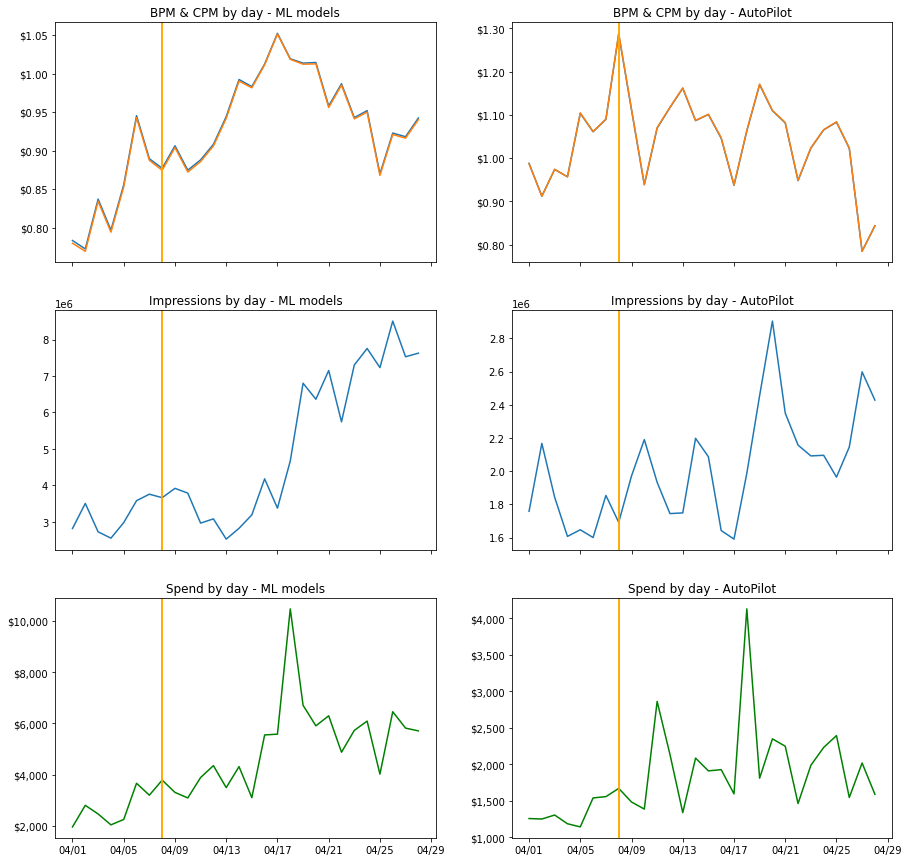

In [704]:
by_day_total_ml_dt = bidding_df_dt[bidding_df_dt.bidder == 'ML'].pivot_table(values = ['total_bid','total_cost','impressions','spend'], index = ['date'], aggfunc = np.sum)
by_day_total_ap_dt = bidding_df_dt[bidding_df_dt.bidder == 'AutoPilot'].pivot_table(values = ['total_bid','total_cost','impressions','spend'], index = ['date'], aggfunc = np.sum)
by_day_total_ml_dt['bpm'] = 1000*by_day_total_ml_dt['total_bid']/by_day_total_ml_dt['impressions']
by_day_total_ml_dt['cpm'] = 1000*by_day_total_ml_dt['total_cost']/by_day_total_ml_dt['impressions']
by_day_total_ap_dt['bpm'] = 1000*by_day_total_ap_dt['total_bid']/by_day_total_ap_dt['impressions']
by_day_total_ap_dt['cpm'] = 1000*by_day_total_ap_dt['total_cost']/by_day_total_ap_dt['impressions']

fig, ax = plt.subplots(3,2, figsize = (15,15), sharex = True)
ax[0,0].plot(by_day_total_ml_dt[['bpm','cpm']])
ax[0,0].yaxis.set_major_formatter('${x:1.2f}')
ax[0,0].set_title('BPM & CPM by day - ML models')
ax[0,0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[0,0].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[1,0].plot(by_day_total_ml_dt['impressions'])
ax[1,0].set_title('Impressions by day - ML models')
ax[1,0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[1,0].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[2,0].plot(by_day_total_ml_dt['spend'], color = 'green')
ax[2,0].yaxis.set_major_formatter('${x:,.0f}')
ax[2,0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax[2,0].set_title('Spend by day - ML models')
ax[2,0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[2,0].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[0,1].plot(by_day_total_ap_dt[['bpm','cpm']])
ax[0,1].yaxis.set_major_formatter('${x:1.2f}')
ax[0,1].set_title('BPM & CPM by day - AutoPilot')
ax[0,1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[0,1].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[1,1].plot(by_day_total_ap_dt['impressions'])
ax[1,1].set_title('Impressions by day - AutoPilot')
ax[1,1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[1,1].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[2,1].plot(by_day_total_ap_dt['spend'], color = 'green')
ax[2,1].yaxis.set_major_formatter('${x:,.0f}')
ax[2,1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax[2,1].set_title('Spend by day - AutoPilot')
ax[2,1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[2,1].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')

<ipython-input-620-ce7ce9bc8363>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['bpm'] = 1000*sub_df['total_bid']/sub_df['impressions']
<ipython-input-620-ce7ce9bc8363>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['cpm'] = 1000*sub_df['total_cost']/sub_df['impressions']


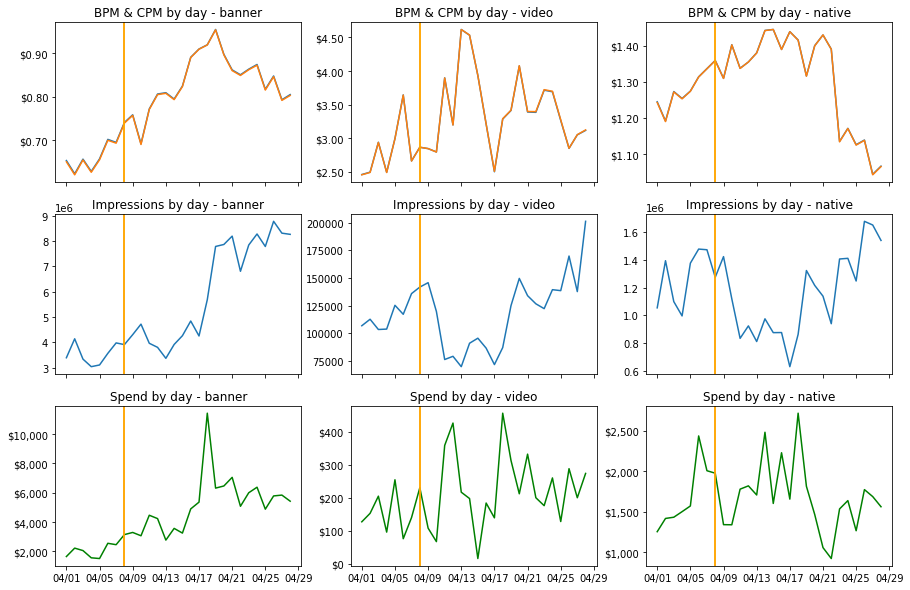

In [620]:
bidding_by_day_by_type_dt = bidding_df_dt.pivot_table(values = ['total_bid','total_cost','impressions','spend'], index = 'date', columns = 'impression type', aggfunc = np.sum)
fig, ax = plt.subplots(3,3, figsize = (15,10), sharex = True)
for n in range(3):
    type_filter = bidding_df_dt['impression type'].unique()[n]

    sub_df = bidding_by_day_by_type_dt.loc[:,bidding_by_day_by_type_dt.columns.get_level_values(1) == type_filter]
    sub_df.columns = sub_df.columns.get_level_values(0)
    sub_df['bpm'] = 1000*sub_df['total_bid']/sub_df['impressions']
    sub_df['cpm'] = 1000*sub_df['total_cost']/sub_df['impressions']
    
    ax[0,n].plot(sub_df[['bpm','cpm']])
    ax[0,n].yaxis.set_major_formatter('${x:1.2f}')
    ax[0,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[0,n].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[0,n].set_title(f'BPM & CPM by day - {type_filter}')
    ax[1,n].plot(sub_df['impressions'])
    ax[1,n].set_title(f'Impressions by day - {type_filter}')
    ax[1,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[1,n].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[2,n].plot(sub_df['spend'], color = 'green')
    ax[2,n].yaxis.set_major_formatter('${x:,.0f}')
    ax[2,n].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax[2,n].set_title(f'Spend by day - {type_filter}')
    ax[2,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[2,n].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')

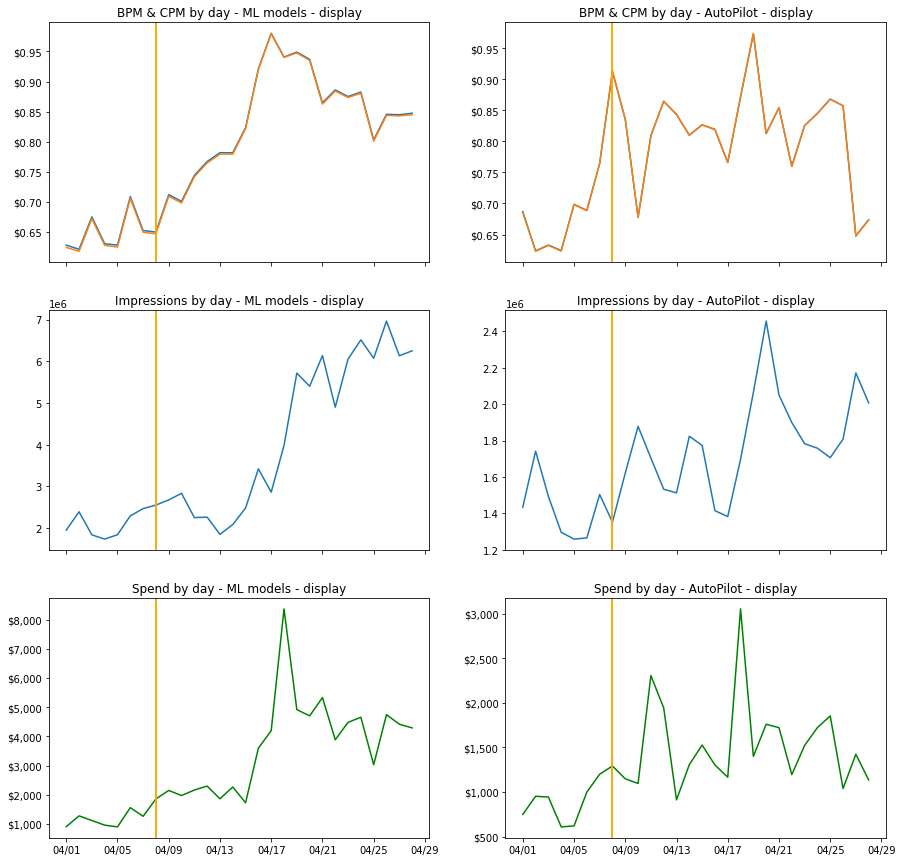

In [734]:
bidding_by_day_banner_ml_dt = bidding_df_dt[(bidding_df_dt.bidder == 'ML') & (bidding_df_dt['impression type'] == 'banner')].pivot_table(values = ['total_bid','total_cost','impressions','spend'], index = 'date', columns = 'impression type', aggfunc = np.sum)
bidding_by_day_banner_ap_dt = bidding_df_dt[(bidding_df_dt.bidder == 'AutoPilot') & (bidding_df_dt['impression type'] == 'banner')].pivot_table(values = ['total_bid','total_cost','impressions','spend'], index = 'date', columns = 'impression type', aggfunc = np.sum)
bidding_by_day_banner_ml_dt['bpm'] = 1000*bidding_by_day_banner_ml_dt['total_bid']/bidding_by_day_banner_ml_dt['impressions']
bidding_by_day_banner_ml_dt['cpm'] = 1000*bidding_by_day_banner_ml_dt['total_cost']/bidding_by_day_banner_ml_dt['impressions']
bidding_by_day_banner_ap_dt['bpm'] = 1000*bidding_by_day_banner_ap_dt['total_bid']/bidding_by_day_banner_ap_dt['impressions']
bidding_by_day_banner_ap_dt['cpm'] = 1000*bidding_by_day_banner_ap_dt['total_cost']/bidding_by_day_banner_ap_dt['impressions']
fig, ax = plt.subplots(3,2, figsize = (15,15), sharex = True)
ax[0,0].plot(bidding_by_day_banner_ml_dt[['bpm','cpm']])
ax[0,0].yaxis.set_major_formatter('${x:1.2f}')
ax[0,0].set_title('BPM & CPM by day - ML models - display')
ax[0,0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[0,0].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[1,0].plot(bidding_by_day_banner_ml_dt['impressions'])
ax[1,0].set_title('Impressions by day - ML models - display')
ax[1,0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[1,0].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[2,0].plot(bidding_by_day_banner_ml_dt['spend'], color = 'green')
ax[2,0].yaxis.set_major_formatter('${x:,.0f}')
ax[2,0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax[2,0].set_title('Spend by day - ML models - display')
ax[2,0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[2,0].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[0,1].plot(bidding_by_day_banner_ap_dt[['bpm','cpm']])
ax[0,1].yaxis.set_major_formatter('${x:1.2f}')
ax[0,1].set_title('BPM & CPM by day - AutoPilot - display')
ax[0,1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[0,1].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[1,1].plot(bidding_by_day_banner_ap_dt['impressions'])
ax[1,1].set_title('Impressions by day - AutoPilot - display')
ax[1,1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[1,1].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[2,1].plot(bidding_by_day_banner_ap_dt['spend'], color = 'green')
ax[2,1].yaxis.set_major_formatter('${x:,.0f}')
ax[2,1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax[2,1].set_title('Spend by day - AutoPilot - display')
ax[2,1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[2,1].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')

<ipython-input-658-2cf24db992e9>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(bidding_df_dt[(bidding_df_dt['impression type'] == 'banner') & (bidding_df_dt.bidder == 'ML')].groupby('ad_size')['spend','impressions'].sum().sort_values('impressions',ascending = False))
<ipython-input-658-2cf24db992e9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['bpm'] = 1000*sub_df['total_bid']/sub_df['impressions']
<ipython-input-658-2cf24db992e9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

             spend  impressions
ad_size                        
320x50    61753.60     90937312
300x250    5946.40      8515328
320x480   15943.68      4029904
480x320    1147.20       274736
728x90       32.00       136448
300x50       32.00        47680
768x1024      0.00        18944
1024x768      0.00         5472


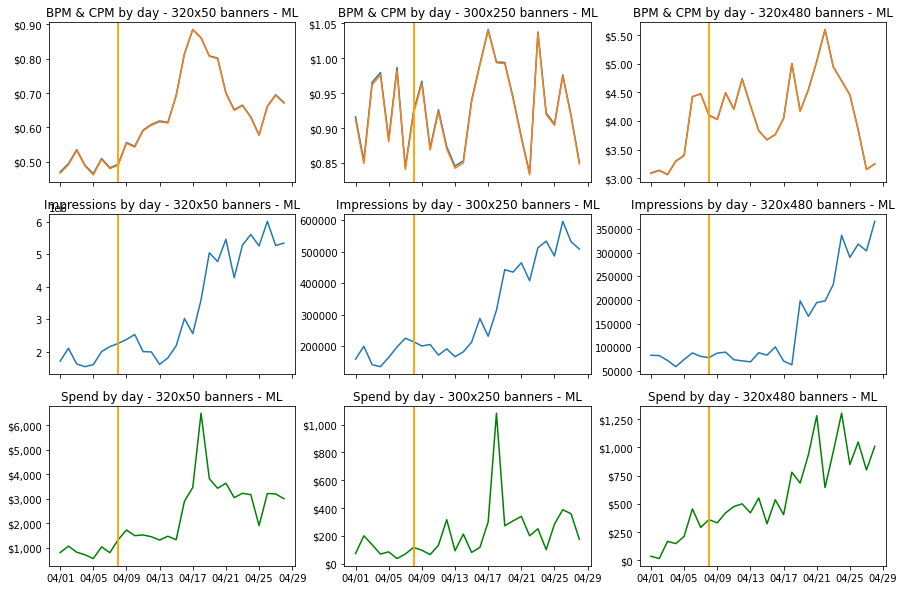

In [658]:
print(bidding_df_dt[(bidding_df_dt['impression type'] == 'banner') & (bidding_df_dt.bidder == 'ML')].groupby('ad_size')['spend','impressions'].sum().sort_values('impressions',ascending = False))

bidding_by_day_by_size_dt = bidding_df_dt[(bidding_df_dt['impression type'] == 'banner') & (bidding_df_dt.bidder == 'ML')].pivot_table(values = ['total_bid','total_cost','impressions','spend'], index = 'date', columns = 'ad_size', aggfunc = np.sum)
fig, ax = plt.subplots(3,3, figsize = (15,10), sharex = True)
for n in range(3):
    size_filter = top_banner_sizes[n]

    sub_df = bidding_by_day_by_size_dt.loc[:,bidding_by_day_by_size_dt.columns.get_level_values(1) == size_filter]
    sub_df.columns = sub_df.columns.get_level_values(0)
    sub_df['bpm'] = 1000*sub_df['total_bid']/sub_df['impressions']
    sub_df['cpm'] = 1000*sub_df['total_cost']/sub_df['impressions']
    
    ax[0,n].plot(sub_df[['bpm','cpm']])
    ax[0,n].yaxis.set_major_formatter('${x:1.2f}')
    ax[0,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[0,n].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[0,n].set_title(f'BPM & CPM by day - {size_filter} banners - ML')
    ax[1,n].plot(sub_df['impressions'])
    ax[1,n].set_title(f'Impressions by day - {size_filter} banners - ML')
    ax[1,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[1,n].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
    ax[2,n].plot(sub_df['spend'], color = 'green')
    ax[2,n].yaxis.set_major_formatter('${x:,.0f}')
    ax[2,n].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax[2,n].set_title(f'Spend by day - {size_filter} banners - ML')
    ax[2,n].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
    ax[2,n].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')

#### Drilling down further....

In [662]:
drilldown_dt = bigquery_client.query(f"""
select
    attr.date
    , case 
        when attr.date <= '{change_start_dt}' then 0 
        when attr.date >= '{change_end_dt}' then 1
    else NULL end as with_change
    , case when cr_model = 'production' or ctr_model = 'production' then 'AutoPilot' else 'ML' end as bidder
    , attr.ad_size
    , attr.hosting_app_id
    , pubs.bundle 
    , attr.sponsored_app_id
    , packages.name as package_name
    , sum(case when cleared > 0 then bid_price else 0 end)*16/1000 as total_bid
    , sum(case when cleared > 0 then settlement_price else 0 end)*16/1000 as total_cost
    , count(case when cleared > 0 then 1 else NULL end)*16 as impressions
    , count(case when clicked > 0 then 1 else NULL end)*16 as clicks
    , count(case when installed > 0 then 1 else NULL end)*16 as installs
    , sum(revenue)*16 as spend
from stats.attributes attr 
join stats.events ev
    on attr.id = ev.id
left join metadata.apps packages
    on attr.sponsored_app_id = packages.app_id
left join metadata.apps pubs
    on attr.hosting_app_id = pubs.app_id
where 
    attr.date >= '{start_dt}'
    and attr.date <= '{end_dt}'
    and attr.ssb_buyer_id = 3549
    and left(attr.id,1) = '0'
    and attr.exchange_id = 3
    and attr.imp_type = 1
group by 1,2,3,4,5,6,7,8
""").to_dataframe()

drilldown_dt

date  with_change     bidder  ad_size  hosting_app_id  \
0       2021-04-28            1  AutoPilot   320x50         1277485   
1       2021-04-26            1  AutoPilot  320x480         1262349   
2       2021-04-24            1  AutoPilot  320x480         1010849   
3       2021-04-19            1  AutoPilot  300x250          405602   
4       2021-04-20            1  AutoPilot  320x480         1123424   
...            ...          ...        ...      ...             ...   
226542  2021-04-21            1         ML   320x50           96379   
226543  2021-04-16            1         ML   320x50         1261178   
226544  2021-04-12            1         ML  320x480          719047   
226545  2021-04-08            0         ML  480x320          913584   
226546  2021-04-25            1         ML   320x50          741913   

                                           bundle  sponsored_app_id  \
0                     com.crazylabs.shoal.of.fish           1002149   
1       com.solitaire.fish.klondike.card.aquarium           1110784   
2                    com.mobilityware.PyramidFree           1110784   
3                                     com.hi5.app           1110784   
4                         in.WordSearch.WordBliss           1110784   
...                                           ...               ...   
226542                           com.myyearbook.m           1207756   
226543                  com.MichalKlacko.Cannon3D           1207756   
226544               com.etermax.preguntados.lite           1207756   
226545                        com.glu.gordondashx           1207756   
226546              com.instantbits.cast.webvideo           1207756   

                                             package_name  total_bid  \
0                           Chapters: Interactive Stories   0.024773   
1       Spades Royale - Best Online Spades Card Games App   4.020001   
2       Spades Royale - Best Online Spades Card Games App   0.227949   
3       Spades Royale - Best Online Spades Card Games App   0.039942   
4       Spades Royale - Best Online Spades Card Games App   0.052045   
...                                                   ...        ...   
226542      Ripio Bitcoin Wallet: the new digital economy   0.001379   
226543      Ripio Bitcoin Wallet: the new digital economy   0.000383   
226544      Ripio Bitcoin Wallet: the new digital economy   0.056437   
226545      Ripio Bitcoin Wallet: the new digital economy   0.012303   
226546      Ripio Bitcoin Wallet: the new digital economy   0.000336   

        total_cost  impressions  clicks  installs  spend  
0          0.02512           48       0         0    NaN  
1          4.01840          288       0         0    NaN  
2          0.22752          144       0         0    NaN  
3          0.03984           48       0         0    NaN  
4          0.05200           32       0         0    NaN  
...            ...          ...     ...       ...    ...  
226542     0.00128           64       0         0    NaN  
226543     0.00032           16       0         0    NaN  
226544     0.05632           16       0         0    NaN  
226545     0.01216           16       0         0    0.0  
226546     0.00032           16       0         0    NaN  

[226547 rows x 14 columns]

In [811]:
top_packages_pivot = drilldown_dt.groupby(['sponsored_app_id'])['impressions','spend'].sum().sort_values('impressions', ascending = False).head(10)
top_packages = top_packages_pivot.index.to_list()[0:4] + top_packages_pivot.index.to_list()[5:20]
top_packages_pivot

<ipython-input-811-cccf1ce30524>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  top_packages_pivot = drilldown_dt.groupby(['sponsored_app_id'])['impressions','spend'].sum().sort_values('impressions', ascending = False).head(10)


impressions     spend
sponsored_app_id                       
951372               38399232  29404.80
502383               24420576  32832.00
71244                18696176  17408.00
56770                16680352   1632.00
284035177            10255040  18304.00
59909                 6363168    336.48
140429                5492592   2496.00
55218                 4506208    624.00
802486                3605696   3936.00
1027927               2980208   1908.00

Text(0.5, 1.0, 'impressions by day')

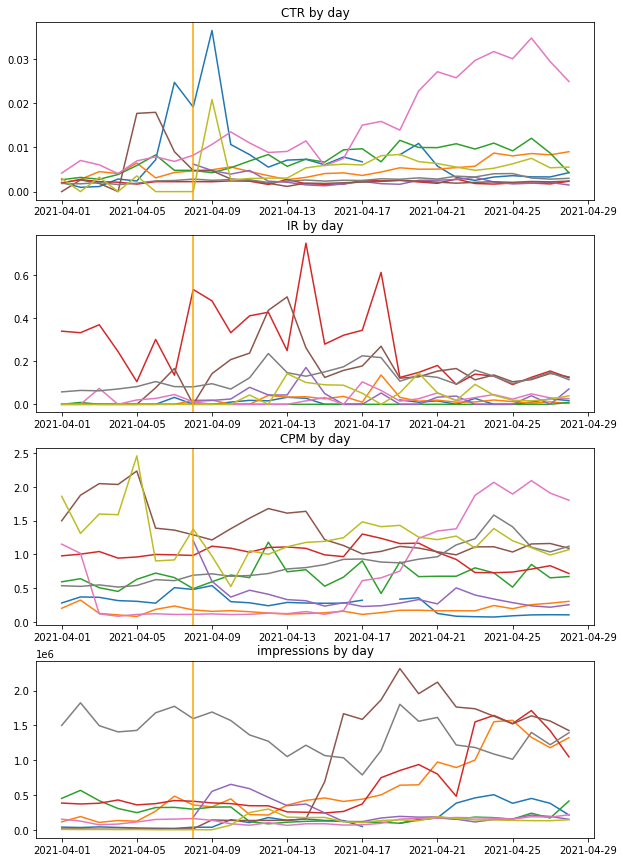

In [848]:
filtered_drilldown = drilldown_dt.loc[(drilldown_dt.sponsored_app_id.isin(top_packages))].pivot_table(values = ['impressions','clicks','installs','total_cost','spend'], index = ['sponsored_app_id','date'], aggfunc = np.sum)
filtered_drilldown['cpm'] = 1000*filtered_drilldown['total_cost']/filtered_drilldown['impressions']
calc_metrics(filtered_drilldown)
top_pub_metrics = filtered_drilldown.reset_index().pivot_table(values = ['ctr','ir','cpm','impressions'], index = 'date', columns = 'sponsored_app_id', aggfunc = np.sum)

fig, ax = plt.subplots(4,1, figsize = (10,15))
ax[0].plot(top_pub_metrics.loc[:, top_pub_metrics.columns[top_pub_metrics.columns.get_level_values(0) == 'ctr']])
ax[0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[0].set_title('CTR by day')
ax[1].plot(top_pub_metrics.loc[:, top_pub_metrics.columns[top_pub_metrics.columns.get_level_values(0) == 'ir']])
ax[1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[1].set_title('IR by day')
ax[2].plot(top_pub_metrics.loc[:, top_pub_metrics.columns[top_pub_metrics.columns.get_level_values(0) == 'cpm']])
ax[2].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[2].set_title('CPM by day')
ax[3].plot(top_pub_metrics.loc[:, top_pub_metrics.columns[top_pub_metrics.columns.get_level_values(0) == 'impressions']])
ax[3].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[3].set_title('impressions by day')

In [832]:
top_pubs_pivot = drilldown_dt.groupby(['hosting_app_id'])['impressions','spend'].sum().sort_values('impressions', ascending = False).head(10)
top_pubs = top_pubs_pivot.index.to_list()[0:10]
top_pubs_pivot

<ipython-input-832-6426f6b5bab5>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  top_pubs_pivot = drilldown_dt.groupby(['hosting_app_id'])['impressions','spend'].sum().sort_values('impressions', ascending = False).head(10)


impressions    spend
hosting_app_id                      
309226             12491616  1404.00
1068506            12456048  6006.40
148078             10609072  4542.88
95814               4207696  1621.60
947773              4074416   887.20
96379               3895824  2221.60
68842               3833408   292.00
1006661             2967440  1364.00
1049297             2544752  9814.40
99827               2464880   542.40

Text(0.5, 1.0, 'impressions by day')

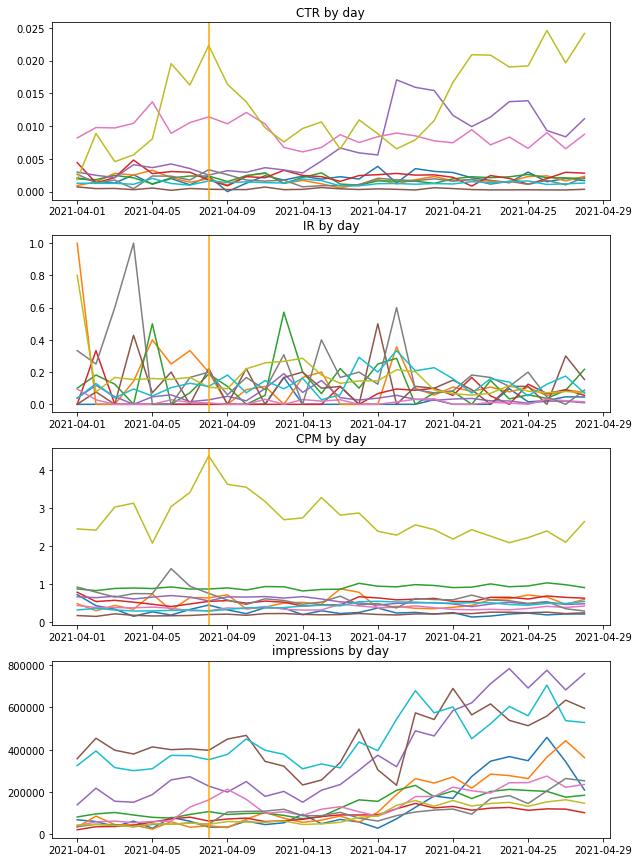

In [837]:
filtered_drilldown = drilldown_dt.loc[(drilldown_dt.hosting_app_id.isin(top_pubs))].pivot_table(values = ['impressions','clicks','installs','total_cost','spend'], index = ['hosting_app_id','date'], aggfunc = np.sum)
filtered_drilldown['cpm'] = 1000*filtered_drilldown['total_cost']/filtered_drilldown['impressions']
calc_metrics(filtered_drilldown)
top_pub_metrics = filtered_drilldown.reset_index().pivot_table(values = ['ctr','ir','cpm','impressions'], index = 'date', columns = 'hosting_app_id', aggfunc = np.sum)

fig, ax = plt.subplots(4,1, figsize = (10,15))
ax[0].plot(top_pub_metrics.loc[:, top_pub_metrics.columns[top_pub_metrics.columns.get_level_values(0) == 'ctr']])
ax[0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[0].set_title('CTR by day')
ax[1].plot(top_pub_metrics.loc[:, top_pub_metrics.columns[top_pub_metrics.columns.get_level_values(0) == 'ir']])
ax[1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[1].set_title('IR by day')
ax[2].plot(top_pub_metrics.loc[:, top_pub_metrics.columns[top_pub_metrics.columns.get_level_values(0) == 'cpm']])
ax[2].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[2].set_title('CPM by day')
ax[3].plot(top_pub_metrics.loc[:, top_pub_metrics.columns[top_pub_metrics.columns.get_level_values(0) == 'impressions']])
ax[3].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[3].set_title('impressions by day')